In [40]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from datetime import datetime

In [41]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NFLX', 'AMZN'] # Just picked a generic TMT basket

start_date = '2020-01-01'
end_date = '2023-01-01'
price_data = yf.download(tickers, start_date, end_date)['Adj Close']

# Gives the daily returns in the selected basket
returns_data = price_data.pct_change().dropna()

[*********************100%***********************]  5 of 5 completed


In [42]:
ff_factors = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', parse_dates=True, index_col=0)
ff_factors.index = pd.to_datetime(ff_factors.index, format='%Y%m%d')



common_dates = ff_factors.index.intersection(returns_data.index)
print(f"Common dates: {len(common_dates)}")

Common dates: 0


In [44]:
returns_data.index = returns_data.index.tz_localize(None)

common_dates = ff_factors.index.intersection(returns_data.index)
print(f"Common dates: {len(common_dates)}")

Common dates: 755


In [50]:
ff_factors = ff_factors.loc[common_dates]

factor_data = returns_data.join(ff_factors[['Mkt-RF', 'SMB', 'HML']], how='inner')
factor_data['RF'] = ff_factors['RF']  # Adding risk-free rate

In [51]:
factor_data

,AAPL,AMZN,GOOGL,MSFT,NFLX,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,
2020-01-03,-0.009722,-0.012139,-0.005231,-0.012451,-0.011855,-0.67,0.38,0.00,0.006
2020-01-06,0.007968,0.014886,0.026654,0.002585,0.030469,0.36,-0.07,-0.55,0.006
2020-01-07,-0.004703,0.002092,-0.001931,-0.009118,-0.015127,-0.19,-0.01,-0.25,0.006
2020-01-08,0.016086,-0.007809,0.007118,0.015928,0.025729,0.47,-0.05,-0.66,0.006
2020-01-09,0.021241,0.004799,0.010498,0.012493,-0.010611,0.65,-0.64,-0.48,0.006
...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.002798,0.017425,0.016750,0.002267,-0.009370,0.51,-0.61,1.16,0.016
2022-12-27,-0.013878,-0.025924,-0.020621,-0.007414,-0.036581,-0.51,-0.74,1.43,0.016
2022-12-28,-0.030685,-0.014692,-0.015677,-0.010255,-0.025654,-1.24,-0.23,-0.29,0.016


In [55]:
factor_loadings = pd.DataFrame(index=tickers, columns=['Mkt-RF', 'SMB', 'HML'])

# Run regression for each stock
for ticker in tickers:
    Y = factor_data[ticker] - factor_data['RF']  # Excess returns
    X = factor_data[['Mkt-RF', 'SMB', 'HML']]
    model = LinearRegression().fit(X, Y)
    factor_loadings.loc[ticker] = model.coef_

print("Factor Loadings:\n", factor_loadings)


Factor Loadings:
          Mkt-RF       SMB       HML
AAPL   0.012059 -0.004037 -0.003752
MSFT   0.011853   -0.0045  -0.00417
GOOGL  0.011015 -0.002358 -0.003143
NFLX   0.009864  0.000095 -0.008467
AMZN    0.01014 -0.002165 -0.006994


In [59]:
factor_loadings['HML'] = pd.to_numeric(factor_loadings['HML'], errors='coerce')
factor_loadings['Mkt-RF'] = pd.to_numeric(factor_loadings['Mkt-RF'], errors='coerce')
factor_loadings['SMB'] = pd.to_numeric(factor_loadings['SMB'], errors='coerce')

In [61]:
# Need to convert to numerics
factor_loadings['HML'] = pd.to_numeric(factor_loadings['HML'], errors='coerce')
factor_loadings['Mkt-RF'] = pd.to_numeric(factor_loadings['Mkt-RF'], errors='coerce')
factor_loadings['SMB'] = pd.to_numeric(factor_loadings['SMB'], errors='coerce')

# Sort stocks by 'HML' loading for long/short strategy
long_stocks = factor_loadings.nlargest(2, 'HML').index
short_stocks = factor_loadings.nsmallest(2, 'HML').index

print("Long stocks:", long_stocks)
print("Short stocks:", short_stocks)

Long stocks: Index(['GOOGL', 'AAPL'], dtype='object')
Short stocks: Index(['NFLX', 'AMZN'], dtype='object')


<Axes: title={'center': 'Long/Short TMT Portfolio Cumulative Returns'}, xlabel='Date'>

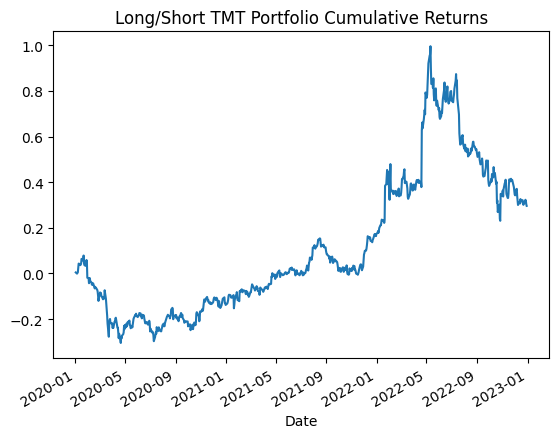

In [62]:
# Calculate daily returns for long and short portfolios
long_returns = factor_data[long_stocks].mean(axis=1)
short_returns = factor_data[short_stocks].mean(axis=1)

# Long/Short portfolio returns
portfolio_returns = long_returns - short_returns

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# Display the result
cumulative_returns.plot(title="Long/Short TMT Portfolio Cumulative Returns")


In [63]:
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: 0.44
